# Unit 1: Foundations of Computer Vision & Convolutions
## Clase: Filtros e Intuición de Convoluciones

**Objetivos de Aprendizaje:**
1. Entender qué es un filtro (kernel) en procesamiento de imágenes
2. Aprender cómo funcionan las convoluciones
3. Ver cómo diferentes kernels extraen diferentes características
4. Conectar con redes neuronales convolucionales

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
import cv2
from scipy import signal
from PIL import Image, ImageDraw
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo
plt.style.use('default')
np.set_printoptions(precision=2, suppress=True)

## Parte 1: Conceptos Fundamentales

### ¿Qué es un Filtro (Kernel)?

Un **filtro** es una pequeña matriz de números que se desliza sobre una imagen. Cada valor del filtro se multiplica por los píxeles correspondientes, y los productos se suman.

**Ejemplo simple: Filtro 3×3 para detectar bordes verticales**

```
[-1   0  +1]
[-2   0  +2]
[-1   0  +1]
```

Este filtro suma los píxeles de la derecha y resta los de la izquierda → **detecta cambios horizontales** (bordes verticales).

## Parte 2: Creación de Imagen de Prueba

Vamos a crear una imagen simple para visualizar claramente cómo funcionan los filtros.

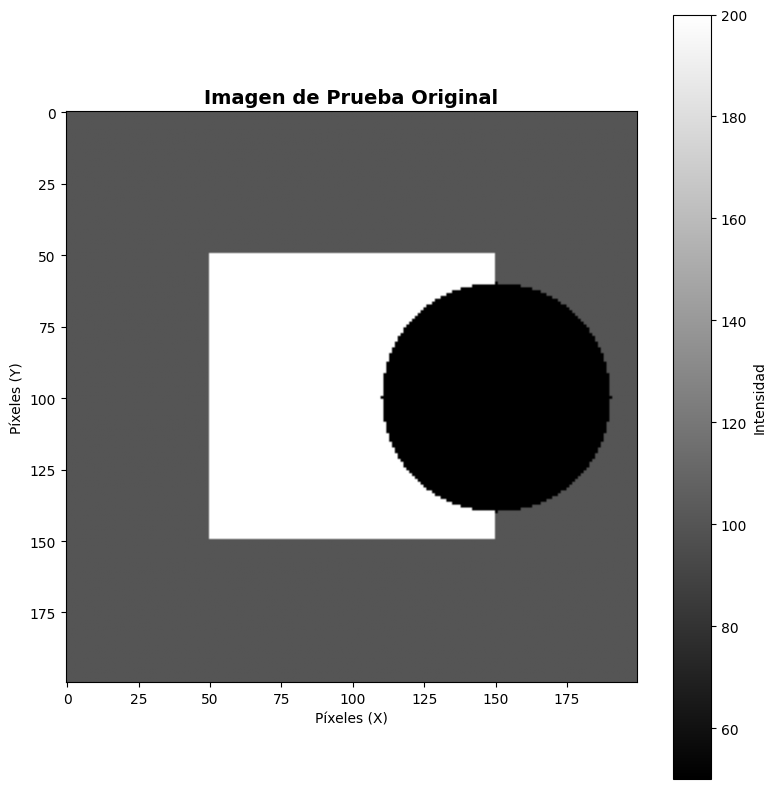

In [2]:
# Crear una imagen simple con características claras
def create_test_image(height=200, width=200):
    """Crea una imagen de prueba con bordes y gradientes."""
    img = np.ones((height, width), dtype=np.uint8) * 100
    
    # Agregar un rectángulo blanco
    img[50:150, 50:150] = 200
    
    # Agregar un círculo
    y, x = np.ogrid[:height, :width]
    mask = (x - 150)**2 + (y - 100)**2 <= 40**2
    img[mask] = 50
    
    return img.astype(np.float32)

test_image = create_test_image()

# Visualizar la imagen original
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
im = ax.imshow(test_image, cmap='gray')
ax.set_title('Imagen de Prueba Original', fontsize=14, fontweight='bold')
ax.set_xlabel('Píxeles (X)')
ax.set_ylabel('Píxeles (Y)')
plt.colorbar(im, ax=ax, label='Intensidad')
plt.tight_layout()
plt.show()

## Parte 3: Demostración Manual de Convolución

Vamos a ver paso a paso cómo funciona una convolución en una pequeña región de la imagen.


VISUALIZACIÓN DE CONVOLUCIÓN: DETECCIÓN DE BORDES VERTICALES


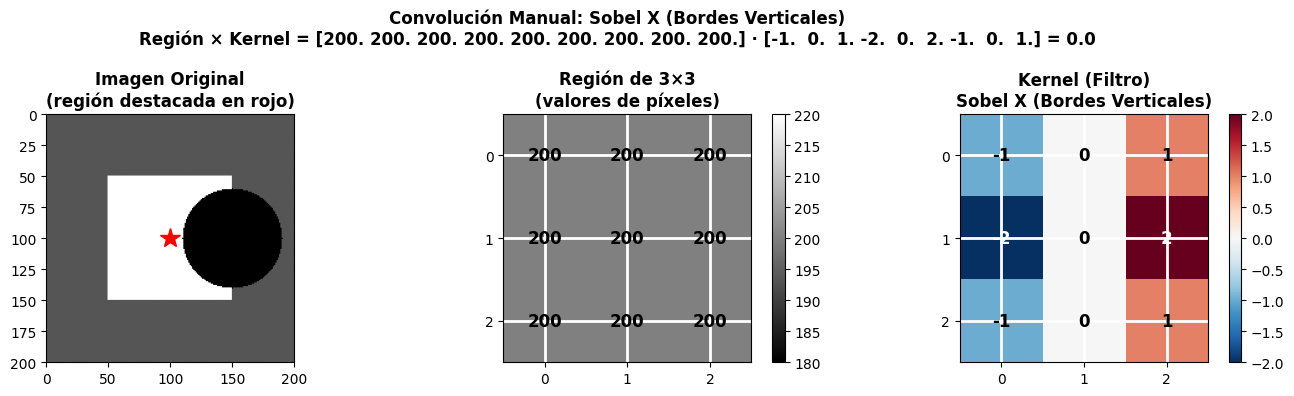

In [3]:
def visualizar_convolucion_manual(imagen, kernel, y_center, x_center, titulo=""):
    """Visualiza el proceso de convolución en una región específica."""
    k_size = kernel.shape[0]
    k_offset = k_size // 2
    
    # Extraer región
    y_start = y_center - k_offset
    x_start = x_center - k_offset
    region = imagen[y_start:y_start+k_size, x_start:x_start+k_size]
    
    # Calcular convolución
    resultado = np.sum(region * kernel)
    
    # Crear figura con grillas
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    
    # Imagen original con región destacada
    ax = axes[0]
    ax.imshow(imagen, cmap='gray')
    rect = patches.Rectangle((x_start, y_start), k_size, k_size, 
                            linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.plot(x_center, y_center, 'r*', markersize=15)
    ax.set_title('Imagen Original\n(región destacada en rojo)', fontweight='bold')
    ax.set_xlim(0, imagen.shape[1])
    ax.set_ylim(imagen.shape[0], 0)
    
    # Región extraída
    ax = axes[1]
    im = ax.imshow(region, cmap='gray')
    ax.set_title(f'Región de {k_size}×{k_size}\n(valores de píxeles)', fontweight='bold')
    # Agregar valores en las celdas
    for i in range(k_size):
        for j in range(k_size):
            ax.text(j, i, f'{region[i, j]:.0f}', ha='center', va='center', 
                   color='white' if region[i, j] < 150 else 'black', fontsize=12, fontweight='bold')
    ax.set_xticks(range(k_size))
    ax.set_yticks(range(k_size))
    ax.grid(True, color='white', linewidth=2)
    plt.colorbar(im, ax=ax)
    
    # Kernel (filtro)
    ax = axes[2]
    im = ax.imshow(kernel, cmap='RdBu_r', vmin=-np.max(np.abs(kernel)), vmax=np.max(np.abs(kernel)))
    ax.set_title(f'Kernel (Filtro)\n{titulo}', fontweight='bold')
    for i in range(k_size):
        for j in range(k_size):
            ax.text(j, i, f'{kernel[i, j]:.0f}', ha='center', va='center', 
                   color='white' if np.abs(kernel[i, j]) > kernel.max()/2 else 'black', fontsize=12, fontweight='bold')
    ax.set_xticks(range(k_size))
    ax.set_yticks(range(k_size))
    ax.grid(True, color='white', linewidth=2)
    plt.colorbar(im, ax=ax)
    
    fig.suptitle(f'Convolución Manual: {titulo}\n' + 
                f'Región × Kernel = {region.flatten()} · {kernel.flatten()} = {resultado:.1f}',
                fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return resultado

# Kernel para detectar bordes verticales (Sobel X)
kernel_vertical = np.array([[-1, 0, 1],
                            [-2, 0, 2],
                            [-1, 0, 1]], dtype=np.float32)

# Visualizar en diferentes posiciones
print("\n" + "="*60)
print("VISUALIZACIÓN DE CONVOLUCIÓN: DETECCIÓN DE BORDES VERTICALES")
print("="*60)

resultado1 = visualizar_convolucion_manual(test_image, kernel_vertical, 100, 100, 
                                          "Sobel X (Bordes Verticales)")

## Parte 4: Diferentes Tipos de Filtros

Veamos cómo diferentes kernels extraen diferentes características de la imagen.

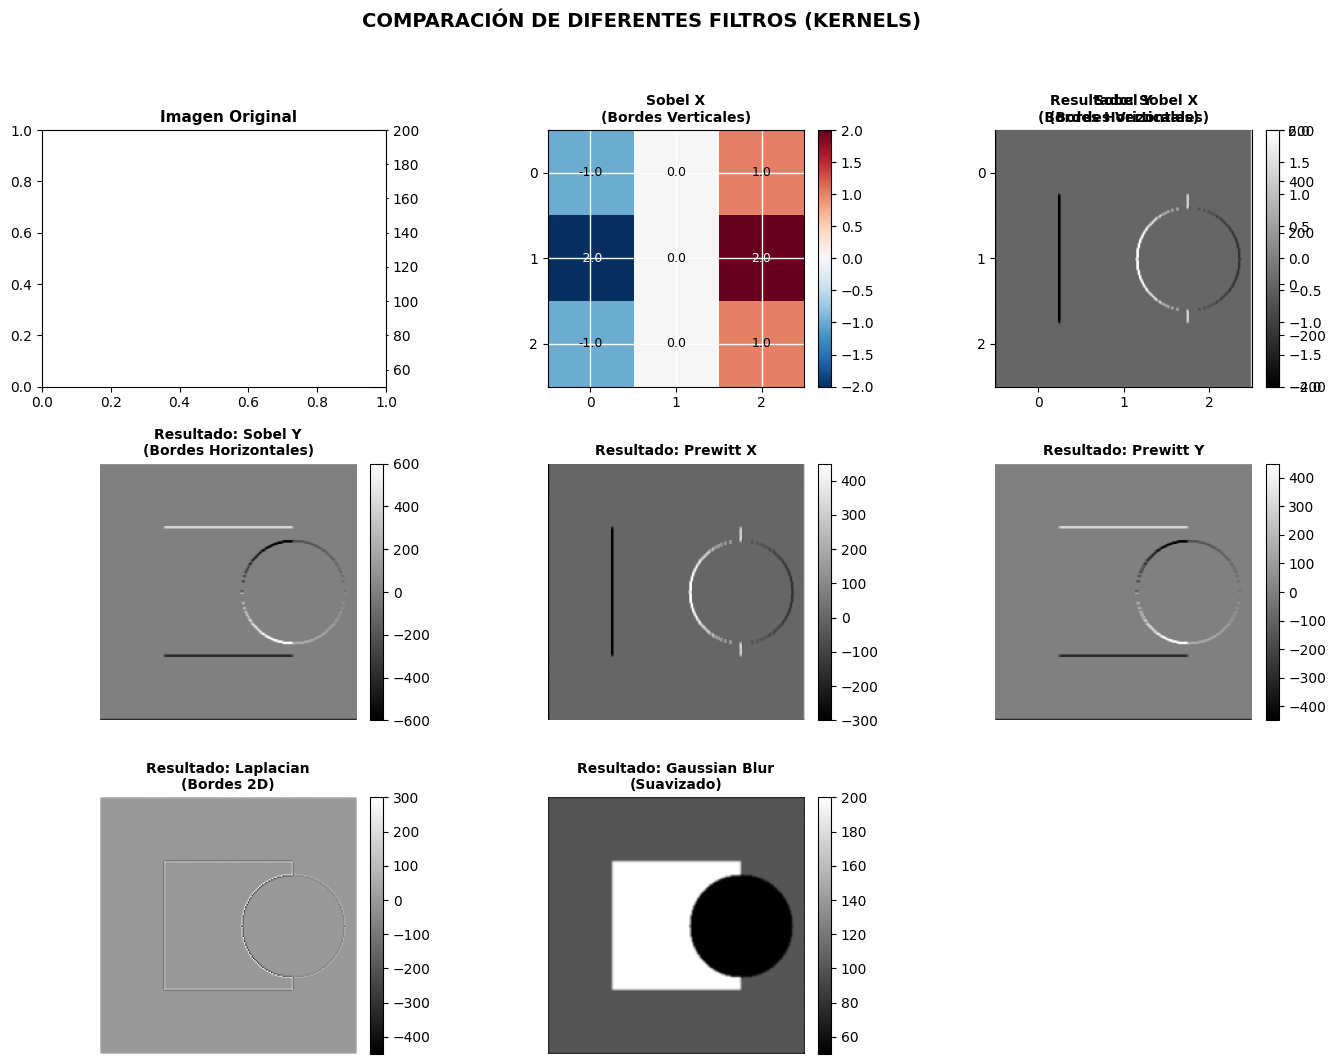


✓ Observa cómo cada filtro resalta características diferentes:
  • Sobel X: detecta cambios verticales (bordes que van de lado a lado)
  • Sobel Y: detecta cambios horizontales (bordes que van arriba-abajo)
  • Laplacian: detecta bordes en todas las direcciones
  • Gaussian Blur: suaviza la imagen, reduce ruido


In [4]:
# Definir diferentes kernels
kernels = {
    'Sobel X\n(Bordes Verticales)': np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32),
    'Sobel Y\n(Bordes Horizontales)': np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=np.float32),
    'Prewitt X': np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], dtype=np.float32),
    'Prewitt Y': np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]], dtype=np.float32),
    'Laplacian\n(Bordes 2D)': np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], dtype=np.float32),
    'Gaussian Blur\n(Suavizado)': np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype=np.float32) / 16,
}

# Aplicar cada filtro
resultados = {}
for nombre, kernel in kernels.items():
    # Usar convolución 2D
    resultado = signal.convolve2d(test_image, kernel, mode='same')
    resultados[nombre] = resultado

# Visualizar todos los resultados
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

# Imagen original
ax = fig.add_subplot(gs[0, 0])
im = ax.imshow(test_image, cmap='gray')
ax.set_title('Imagen Original', fontweight='bold', fontsize=11)
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Kernels
kernel_names = list(kernels.keys())
for idx, (nombre, kernel) in enumerate(kernels.items()):
    ax = fig.add_subplot(gs[0, 1 if idx == 0 else 2 if idx == 1 else 0])
    if idx > 1:
        break
    im = ax.imshow(kernel, cmap='RdBu_r', vmin=-np.max(np.abs(kernel)), vmax=np.max(np.abs(kernel)))
    ax.set_title(nombre, fontweight='bold', fontsize=10)
    for i in range(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            ax.text(j, i, f'{kernel[i, j]:.1f}', ha='center', va='center', 
                   fontsize=9, color='white' if np.abs(kernel[i, j]) > kernel.max()/2 else 'black')
    ax.set_xticks(range(kernel.shape[1]))
    ax.set_yticks(range(kernel.shape[0]))
    ax.grid(True, color='white', linewidth=1)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Resultados de filtros
for idx, (nombre, resultado) in enumerate(resultados.items()):
    ax = fig.add_subplot(gs[(idx+2)//3, (idx+2)%3])
    im = ax.imshow(resultado, cmap='gray')
    ax.set_title(f'Resultado: {nombre}', fontweight='bold', fontsize=10)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

fig.suptitle('COMPARACIÓN DE DIFERENTES FILTROS (KERNELS)', fontsize=14, fontweight='bold')
plt.show()

print("\n✓ Observa cómo cada filtro resalta características diferentes:")
print("  • Sobel X: detecta cambios verticales (bordes que van de lado a lado)")
print("  • Sobel Y: detecta cambios horizontales (bordes que van arriba-abajo)")
print("  • Laplacian: detecta bordes en todas las direcciones")
print("  • Gaussian Blur: suaviza la imagen, reduce ruido")

## Parte 5: Magnitud y Dirección de Gradientes

Cuando combinamos Sobel X y Sobel Y, podemos calcular:
- **Magnitud**: Fuerza del borde
- **Dirección**: Orientación del borde

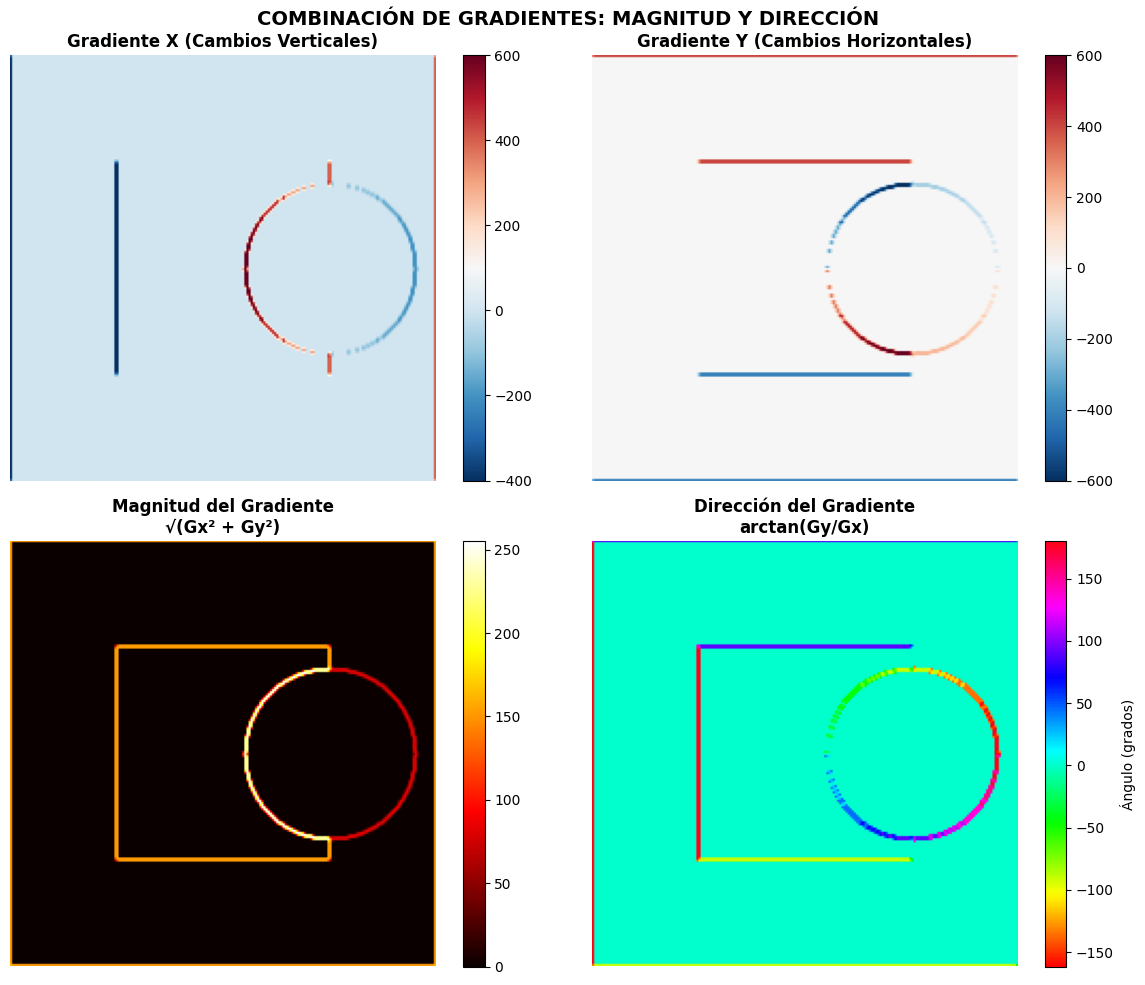

In [5]:
# Calcular gradientes X e Y
kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=np.float32)

grad_x = signal.convolve2d(test_image, kernel_x, mode='same')
grad_y = signal.convolve2d(test_image, kernel_y, mode='same')

# Magnitud: √(Gx² + Gy²)
magnitud = np.sqrt(grad_x**2 + grad_y**2)
magnitud = (magnitud / magnitud.max() * 255).astype(np.uint8)

# Dirección: arctan(Gy / Gx)
direccion = np.arctan2(grad_y, grad_x) * 180 / np.pi

# Visualizar
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Grad X
im = axes[0, 0].imshow(grad_x, cmap='RdBu_r')
axes[0, 0].set_title('Gradiente X (Cambios Verticales)', fontweight='bold')
axes[0, 0].axis('off')
plt.colorbar(im, ax=axes[0, 0])

# Grad Y
im = axes[0, 1].imshow(grad_y, cmap='RdBu_r')
axes[0, 1].set_title('Gradiente Y (Cambios Horizontales)', fontweight='bold')
axes[0, 1].axis('off')
plt.colorbar(im, ax=axes[0, 1])

# Magnitud
im = axes[1, 0].imshow(magnitud, cmap='hot')
axes[1, 0].set_title('Magnitud del Gradiente\n√(Gx² + Gy²)', fontweight='bold')
axes[1, 0].axis('off')
plt.colorbar(im, ax=axes[1, 0])

# Dirección
im = axes[1, 1].imshow(direccion, cmap='hsv')
axes[1, 1].set_title('Dirección del Gradiente\narctan(Gy/Gx)', fontweight='bold')
axes[1, 1].axis('off')
plt.colorbar(im, ax=axes[1, 1], label='Ángulo (grados)')

fig.suptitle('COMBINACIÓN DE GRADIENTES: MAGNITUD Y DIRECCIÓN', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Parte 6: Convolución con una Imagen Real

Veamos cómo funcionan los filtros con una imagen más compleja.

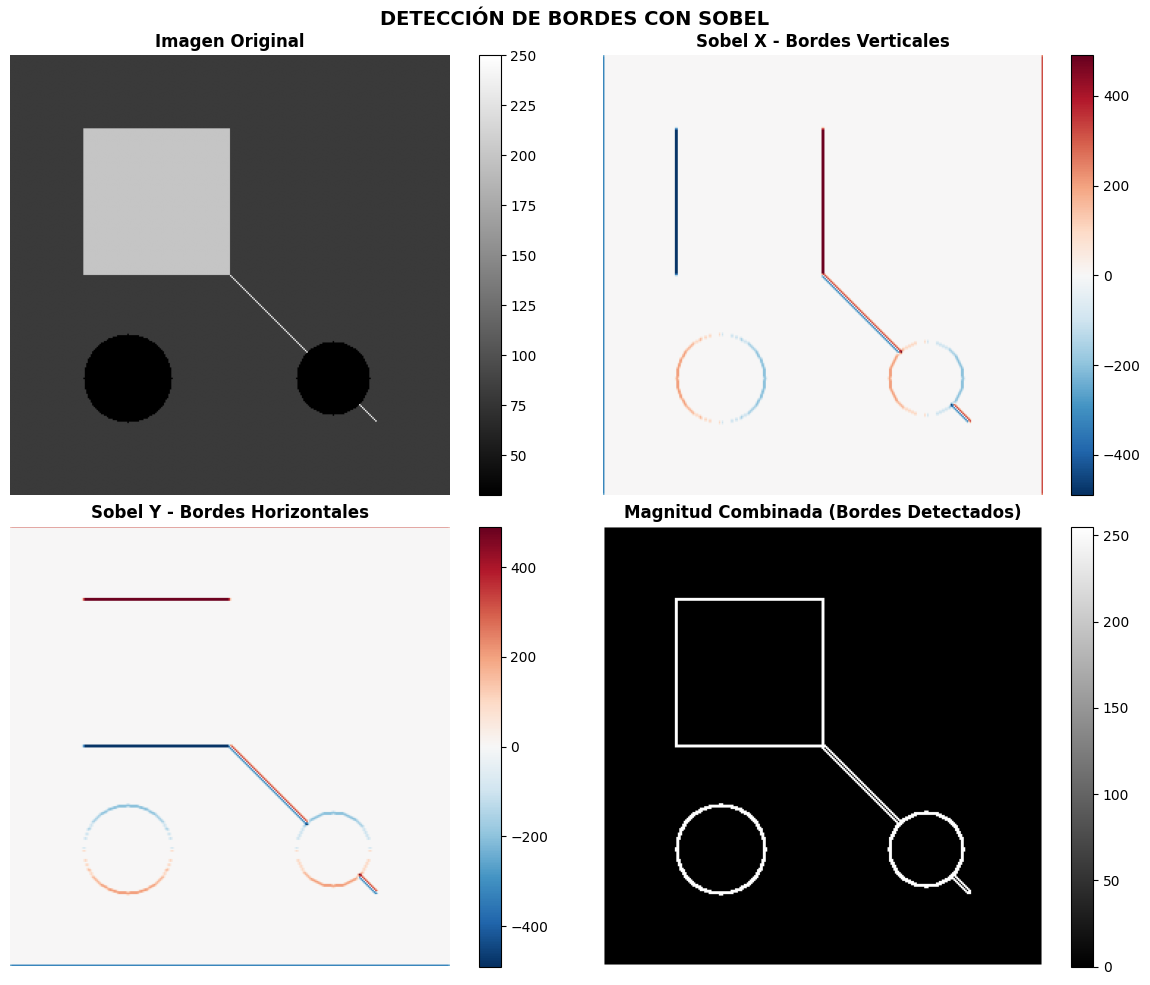

In [6]:
# Crear una imagen más compleja
def crear_imagen_compleja():
    """Crea una imagen con múltiples características."""
    img = np.ones((300, 300), dtype=np.uint8) * 80
    
    # Rectángulo
    img[50:150, 50:150] = 200
    
    # Línea diagonal
    for i in range(100):
        img[150+i, 150+i] = 250
    
    # Círculos
    y, x = np.ogrid[:300, :300]
    for cx, cy, r in [(80, 220, 30), (220, 220, 25)]:
        mask = (x - cx)**2 + (y - cy)**2 <= r**2
        img[mask] = 30
    
    return img.astype(np.float32)

imagen_compleja = crear_imagen_compleja()

# Aplicar filtros
sobel_x = signal.convolve2d(imagen_compleja, kernel_x, mode='same')
sobel_y = signal.convolve2d(imagen_compleja, kernel_y, mode='same')
magnitud_compleja = np.sqrt(sobel_x**2 + sobel_y**2)

# Umbralizar para ver bordes claramente
bordes = (magnitud_compleja > np.percentile(magnitud_compleja, 70)).astype(np.uint8) * 255

# Visualizar
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

im = axes[0, 0].imshow(imagen_compleja, cmap='gray')
axes[0, 0].set_title('Imagen Original', fontweight='bold', fontsize=12)
axes[0, 0].axis('off')
plt.colorbar(im, ax=axes[0, 0])

im = axes[0, 1].imshow(sobel_x, cmap='RdBu_r')
axes[0, 1].set_title('Sobel X - Bordes Verticales', fontweight='bold', fontsize=12)
axes[0, 1].axis('off')
plt.colorbar(im, ax=axes[0, 1])

im = axes[1, 0].imshow(sobel_y, cmap='RdBu_r')
axes[1, 0].set_title('Sobel Y - Bordes Horizontales', fontweight='bold', fontsize=12)
axes[1, 0].axis('off')
plt.colorbar(im, ax=axes[1, 0])

im = axes[1, 1].imshow(bordes, cmap='gray')
axes[1, 1].set_title('Magnitud Combinada (Bordes Detectados)', fontweight='bold', fontsize=12)
axes[1, 1].axis('off')
plt.colorbar(im, ax=axes[1, 1])

fig.suptitle('DETECCIÓN DE BORDES CON SOBEL', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Parte 7: Stacking de Filtros

En redes neuronales convolucionales, usamos **múltiples filtros** para extraer diferentes características. Cada filtro aprende a detectar patrones distintos.

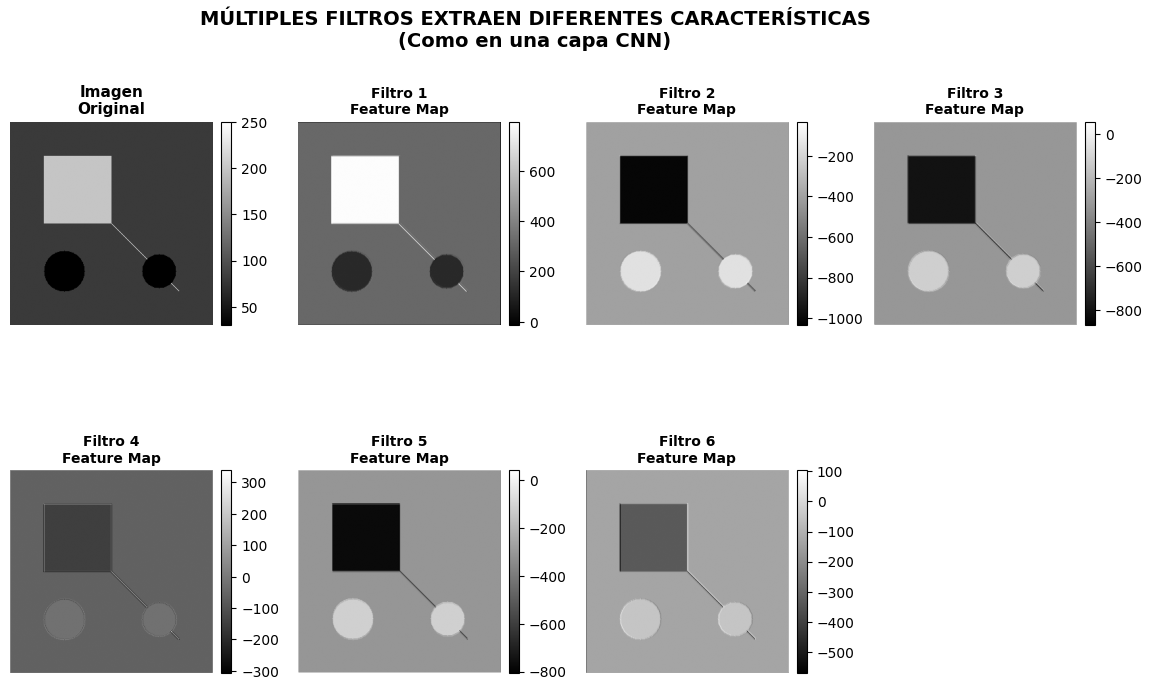


✓ En una CNN:
  • La imagen original: (300, 300)
  • Cada filtro genera un 'Feature Map': (300, 300)
  • Con 6 filtros tenemos 6 características diferentes
  • Stack de feature maps: (300, 300, 6)

✓ Las redes neuronales aprenden estos filtros automáticamente durante el entrenamiento!


In [7]:
# Crear múltiples filtros aleatorios para simular una capa CNN
np.random.seed(42)
num_filtros = 6

# Generar kernels aleatorios
kernels_aleatorios = [np.random.randn(3, 3) for _ in range(num_filtros)]

# Aplicar todos los filtros
feature_maps = []
for kernel in kernels_aleatorios:
    fm = signal.convolve2d(imagen_compleja, kernel, mode='same')
    feature_maps.append(fm)

# Visualizar
fig = plt.figure(figsize=(14, 8))
gs = GridSpec(2, 4, figure=fig, hspace=0.3, wspace=0.3)

# Imagen original
ax = fig.add_subplot(gs[0, 0])
im = ax.imshow(imagen_compleja, cmap='gray')
ax.set_title('Imagen\nOriginal', fontweight='bold', fontsize=11)
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Feature maps
for idx, (kernel, fm) in enumerate(zip(kernels_aleatorios, feature_maps)):
    row = (idx + 1) // 4
    col = (idx + 1) % 4
    ax = fig.add_subplot(gs[row, col])
    
    im = ax.imshow(fm, cmap='gray')
    ax.set_title(f'Filtro {idx+1}\nFeature Map', fontweight='bold', fontsize=10)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

fig.suptitle('MÚLTIPLES FILTROS EXTRAEN DIFERENTES CARACTERÍSTICAS\n(Como en una capa CNN)',
             fontsize=14, fontweight='bold')
plt.show()

print("\n✓ En una CNN:")
print(f"  • La imagen original: {imagen_compleja.shape}")
print(f"  • Cada filtro genera un 'Feature Map': {feature_maps[0].shape}")
print(f"  • Con 6 filtros tenemos 6 características diferentes")
print(f"  • Stack de feature maps: ({imagen_compleja.shape[0]}, {imagen_compleja.shape[1]}, {len(feature_maps)})")
print("\n✓ Las redes neuronales aprenden estos filtros automáticamente durante el entrenamiento!")

## Parte 8: Visualización Detallada con Zoom y Grilla

Veamos en detalle cómo una convolución transforma los píxeles.


ZONA 1: Centro del rectángulo (borde fuerte esperado)


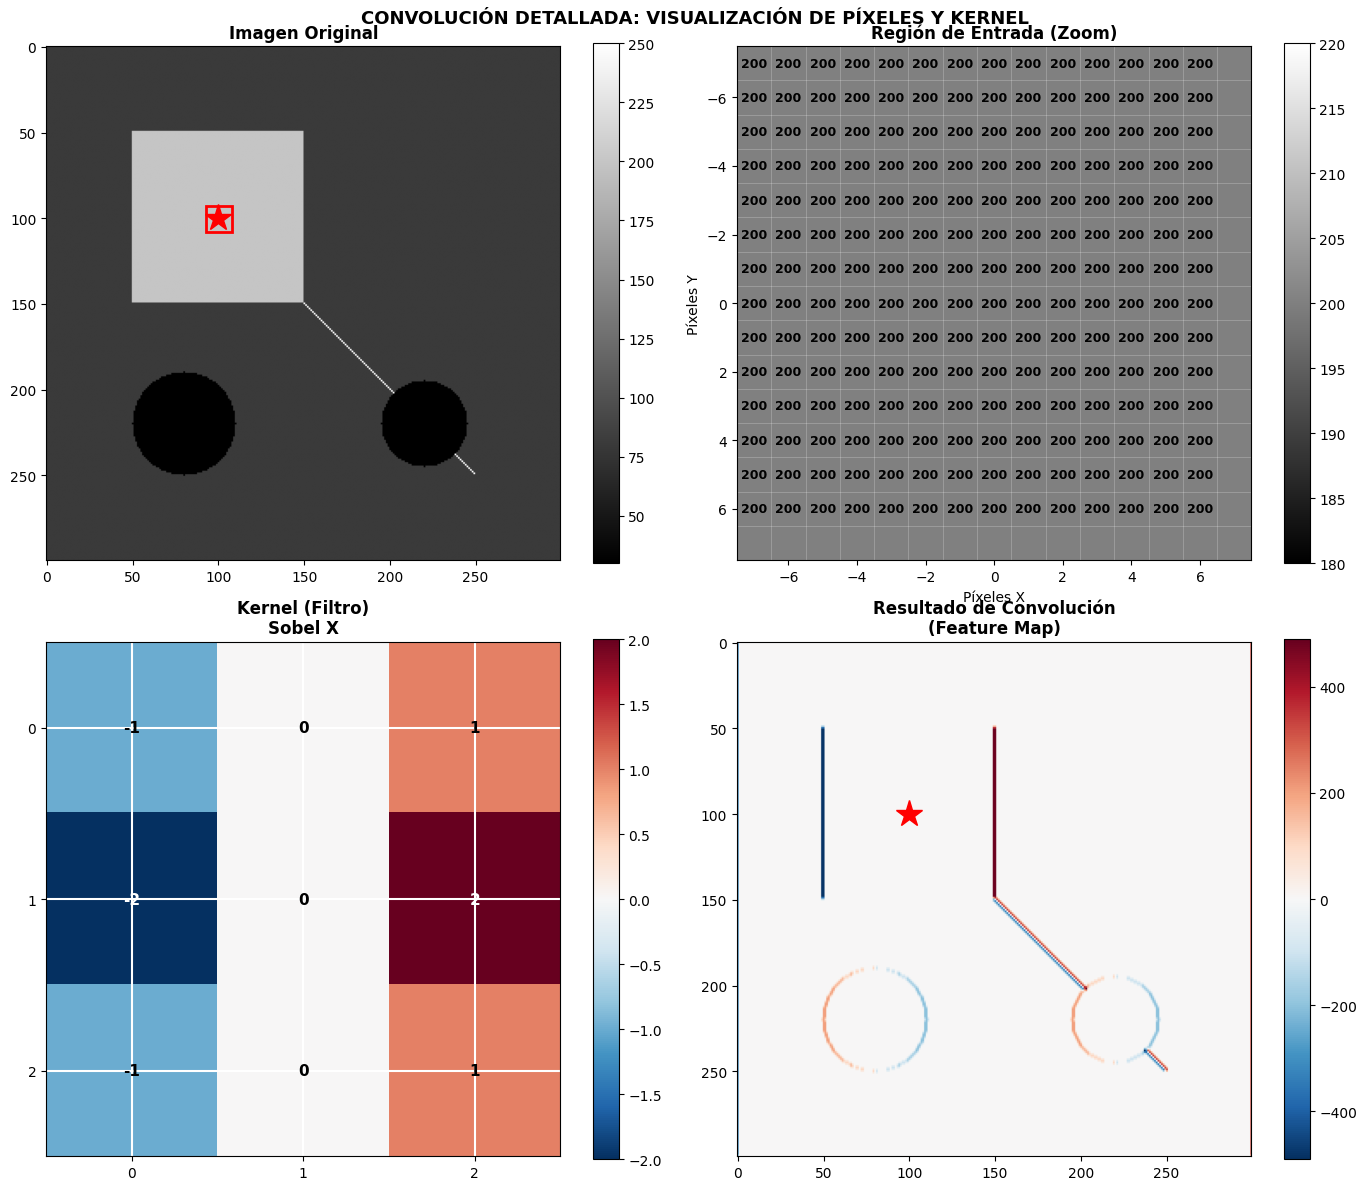


ZONA 2: Centro de región uniforme (resultado pequeño esperado)


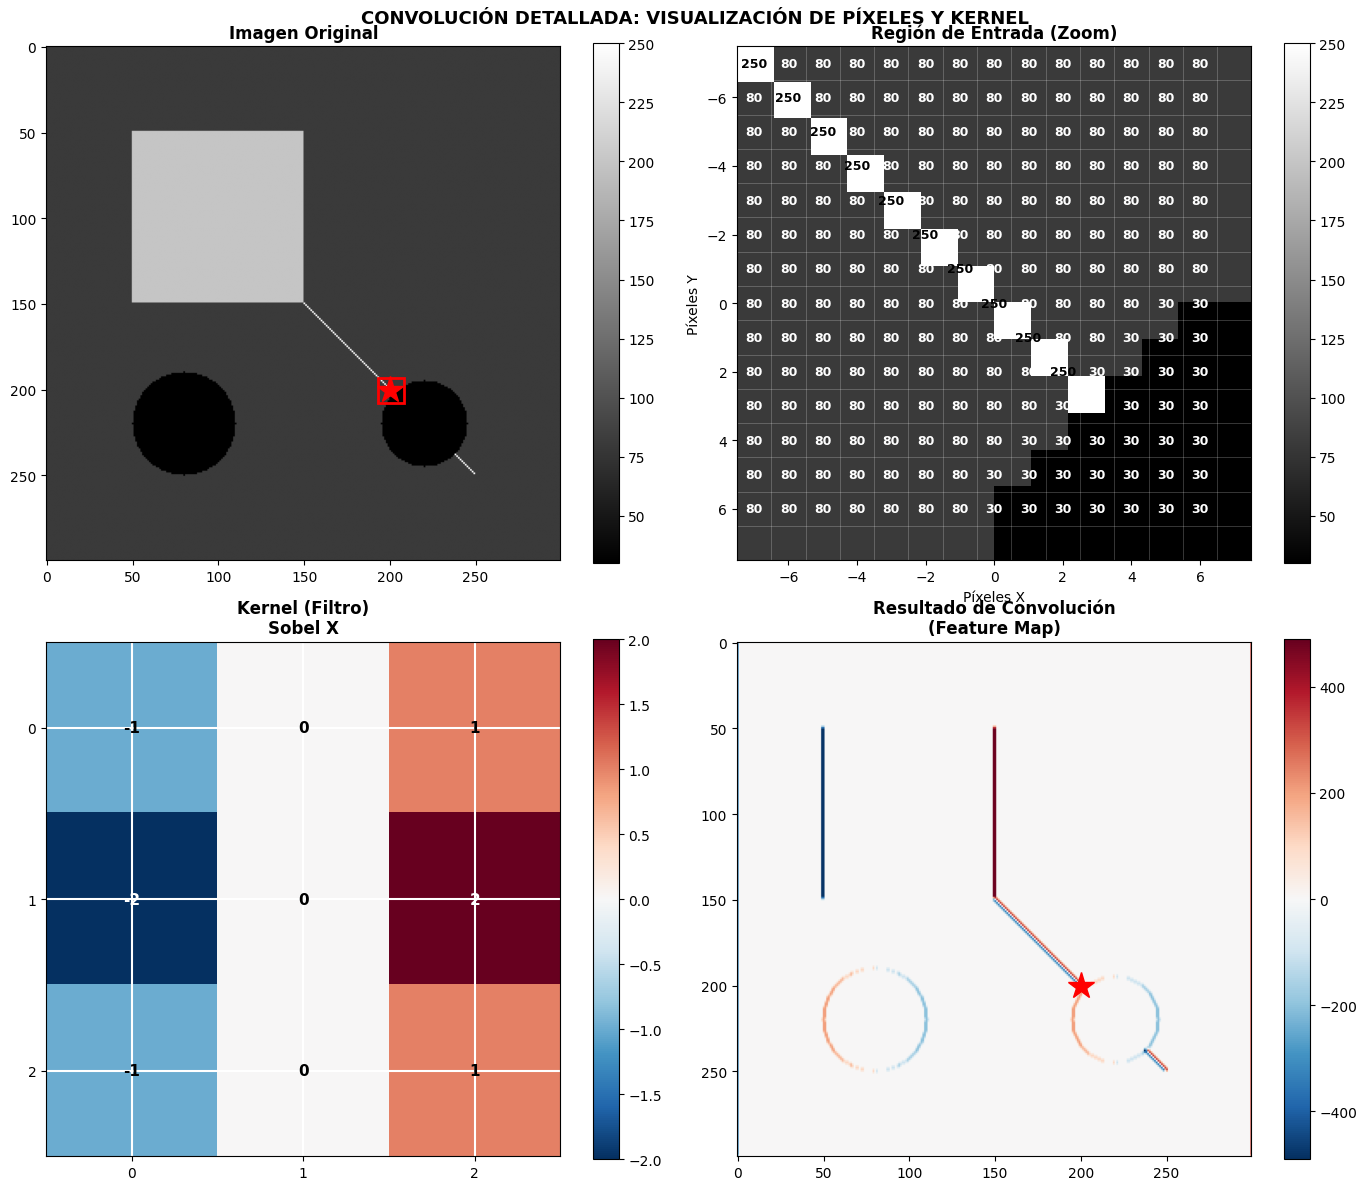

In [8]:
def visualizar_zona_pixeles(imagen, resultado, kernel, y_region, x_region, tamaño_zoom=10):
    """Visualiza una zona pequeña con grilla de píxeles."""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Imagen original con región destacada
    ax = axes[0, 0]
    im = ax.imshow(imagen, cmap='gray')
    ax.set_title('Imagen Original', fontweight='bold', fontsize=12)
    rect = patches.Rectangle((x_region-tamaño_zoom//2, y_region-tamaño_zoom//2), 
                             tamaño_zoom, tamaño_zoom, 
                             linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.plot(x_region, y_region, 'r*', markersize=20)
    plt.colorbar(im, ax=ax)
    
    # Zona con grilla de píxeles (entrada)
    ax = axes[0, 1]
    zona_entrada = imagen[y_region-tamaño_zoom//2:y_region+tamaño_zoom//2, 
                          x_region-tamaño_zoom//2:x_region+tamaño_zoom//2]
    im = ax.imshow(zona_entrada, cmap='gray', extent=[-tamaño_zoom/2, tamaño_zoom/2, tamaño_zoom/2, -tamaño_zoom/2])
    ax.set_title('Región de Entrada (Zoom)', fontweight='bold', fontsize=12)
    ax.set_xlabel('Píxeles X')
    ax.set_ylabel('Píxeles Y')
    
    # Grilla
    for i in np.arange(-tamaño_zoom/2, tamaño_zoom/2, 1):
        ax.axhline(y=i, color='white', linewidth=0.5, alpha=0.3)
        ax.axvline(x=i, color='white', linewidth=0.5, alpha=0.3)
    
    # Valores de píxeles en celdas
    for i in range(zona_entrada.shape[0]):
        for j in range(zona_entrada.shape[1]):
            y_pos = -tamaño_zoom/2 + i + 0.5
            x_pos = -tamaño_zoom/2 + j + 0.5
            ax.text(x_pos, y_pos, f'{zona_entrada[i,j]:.0f}', 
                   ha='center', va='center', fontsize=9, fontweight='bold',
                   color='white' if zona_entrada[i,j] < 150 else 'black')
    
    plt.colorbar(im, ax=ax)
    
    # Kernel
    ax = axes[1, 0]
    im = ax.imshow(kernel, cmap='RdBu_r', vmin=-np.max(np.abs(kernel)), vmax=np.max(np.abs(kernel)))
    ax.set_title('Kernel (Filtro)\nSobel X', fontweight='bold', fontsize=12)
    for i in range(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            ax.text(j, i, f'{kernel[i,j]:.0f}', ha='center', va='center', 
                   fontsize=11, fontweight='bold',
                   color='white' if np.abs(kernel[i,j]) > kernel.max()/2 else 'black')
    ax.set_xticks(range(kernel.shape[1]))
    ax.set_yticks(range(kernel.shape[0]))
    ax.grid(True, color='white', linewidth=1.5)
    plt.colorbar(im, ax=ax)
    
    # Resultado
    ax = axes[1, 1]
    im = ax.imshow(resultado, cmap='RdBu_r')
    ax.set_title('Resultado de Convolución\n(Feature Map)', fontweight='bold', fontsize=12)
    
    # Marcar la posición actual
    zona_resultado = resultado[max(0, y_region-tamaño_zoom//2):y_region+tamaño_zoom//2, 
                              max(0, x_region-tamaño_zoom//2):x_region+tamaño_zoom//2]
    ax.plot(x_region, y_region, 'r*', markersize=20)
    
    plt.colorbar(im, ax=ax)
    
    fig.suptitle('CONVOLUCIÓN DETALLADA: VISUALIZACIÓN DE PÍXELES Y KERNEL',
                fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Aplicar convolución
resultado_convolucion = signal.convolve2d(imagen_compleja, kernel_x, mode='same')

# Visualizar en dos posiciones interesantes
print("\nZONA 1: Centro del rectángulo (borde fuerte esperado)")
visualizar_zona_pixeles(imagen_compleja, resultado_convolucion, kernel_x, 100, 100, tamaño_zoom=15)

print("\nZONA 2: Centro de región uniforme (resultado pequeño esperado)")
visualizar_zona_pixeles(imagen_compleja, resultado_convolucion, kernel_x, 200, 200, tamaño_zoom=15)

## Resumen y Conceptos Clave

### 📌 Puntos Importantes:

1. **¿Qué es un Kernel?**
   - Una pequeña matriz de números (típicamente 3×3, 5×5, etc.)
   - Se desliza sobre la imagen
   - Multiplica cada valor del kernel por el píxel correspondiente
   - Suma todos los productos → 1 píxel en la salida

2. **¿Cómo extraen características?**
   - Los valores del kernel determinan qué patrón se detecta
   - Sobel X detecta cambios horizontales (bordes verticales)
   - Sobel Y detecta cambios verticales (bordes horizontales)
   - Laplacian detecta cambios en todas las direcciones

3. **Stacking de Filtros**
   - Una capa CNN no usa 1, sino múltiples filtros (32, 64, 128...)
   - Cada filtro aprende a detectar un patrón diferente
   - Output: "Feature Maps" que se apilan

4. **Aprendizaje en CNN**
   - Los valores de los kernels se ajustan durante el entrenamiento
   - El algoritmo aprende qué kernels son útiles para la tarea
   - Primeras capas: detectan bordes y texturas simples
   - Capas más profundas: detectan formas complejas y objetos

5. **Ventajas sobre MLP**
   - Fewer parameters (kernels 3×3 vs capas densas)
   - Detección local de patrones (no global)
   - Invariancia a trasformaciones pequeñas

---

**Próxima clase:** Redes Neuronales Convolucionales (CNN) - Entenderás cómo se apilan muchas de estas capas para crear clasificadores poderosos.